In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from models import MoDL,MoDL_clean
from losses import nrmse
from ops import A_forward, A_adjoint, fft,ifft
from maskgen import mask_load, fixed_mask_gen
from dotmap import DotMap
from datagen import MCFullFastMRI
from torch.utils.data import DataLoader

/home/blevac/anaconda3/envs/torch1_10stable/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 16
R = 4

val_cont = torch.load('/csiNAS/asad/data/brain_fastMRI/val_samples_ambient/sample_%d.pt'%sample)
print(val_cont.keys())
# fs_ksp = val_cont['ksp'][None].cpu()
# maps = val_cont['s_map'][None].cpu()
# a_mask = val_cont['mask_%d'%R][None].cpu()
gt_img = val_cont['gt'][None,None].cpu()
fs_ksp = fft(gt_img)
a_mask = torch.tensor(fixed_mask_gen(ksp_shape=fs_ksp.shape,R=R,ACS_p=0.0625))
maps = torch.ones((1,1,1,1))

# samp_pat = '1D'
# train_dataset = MCFullFastMRI(samp_pat = samp_pat, downsample=R, direction = 'y', mask='single_fixed', coil='single_coil')
# train_loader  = DataLoader(train_dataset, batch_size=1,
#                             shuffle=True, num_workers=1, drop_last=True,
#                             pin_memory=True)
# iterator = iter(train_dataset)
# sample = next(iterator)


dict_keys(['gt', 'ksp', 's_map', 'mask_2', 'mask_3', 'mask_4', 'mask_5', 'mask_6', 'mask_7', 'mask_8', 'mask_9', 'mask_10', 'mask_12', 'mask_14', 'mask_16', 'mask_18', 'mask_20', 'norm_consts_99'])


In [3]:
recon_hparams = DotMap()
recon_hparams.verbose      = False
recon_hparams.batch_size   = 1
recon_hparams.max_cg_steps = 6
recon_hparams.cg_eps       = 1e-6
recon_hparams.unrolls      = 6
recon_hparams.logging      = False
recon_hparams.img_channels = 16
recon_hparams.img_blocks   = 4
recon_hparams.img_arch     = 'UNet'
recon_hparams.l2lam_train = True
recon_hparams.l2lam_init  = 0.1

In [4]:
# supervised MoDL
R = 4
sparsity = 0.25
coil = 'single_coil'
mask = 'single_fixed'
file = '/csiNAS2/slow/brett/SSMS_results/results_2_15_24/MoDL_supervised/%s_%s/trainR%d_1Dpat_Sparsity%.3e/ckpt_4.pt'%(coil, mask,R, sparsity)
cont = torch.load(file)
# create model and load weights
model = MoDL(recon_hparams).cpu()
model.load_state_dict(cont['recon_model_state_dict'])
# fm_mask = torch.tensor(mask_load(ksp_shape=fs_ksp.shape, R=4, ACS_p=0.0625, pe_dir=-1))

fm_mask = a_mask
fm_ksp = fs_ksp*fm_mask
# fm_mask = sample['full_mask']
# fm_ksp = sample['meas_ksp']
# maps = torch.ones((1,1,1,1))


x_MoDL= model(ksp=fm_ksp, maps=maps, mask=fm_mask[0], meta_unrolls=6)
nrmse_MoDL= nrmse(abs(gt_img[0,0]), abs(x_MoDL[0])).item()

In [5]:
# SSDU
R = 4
sparsity = 0.25
coil = 'single_coil'
mask = 'single_fixed'
file = '/csiNAS2/slow/brett/SSMS_results/results_2_15_24/SSDU/%s_%s/trainR%d_1Dpat_LearnedSparsity%.3e/rho2.0e-01/ckpt_9.pt'%(coil, mask, R, sparsity)
cont = torch.load(file)
model = MoDL(recon_hparams).cpu()
model.load_state_dict(cont['recon_model_state_dict'])
fm_mask = a_mask
fm_ksp = fs_ksp*fm_mask

x_SSDU= model(ksp=fm_ksp, maps=maps, mask=fm_mask[0], meta_unrolls=6)
nrmse_SSDU= nrmse(abs(gt_img[0,0]), abs(x_SSDU[0])).item()

In [6]:
# MOI
R = 4
virtual_ops = 4
coil = 'single_coil'
mask = 'single_fixed'
file = '/csiNAS2/slow/brett/SSMS_results/results_2_15_24/MOI/%s_%s/1D_R%d/virtual_ops_%d/ckpt_9.pt'%(coil, mask,R,virtual_ops)
cont = torch.load(file)
model = MoDL(recon_hparams).cpu()
model.load_state_dict(cont['recon_model_state_dict'])
fm_mask = a_mask
fm_ksp = fs_ksp*fm_mask

x_MOI= model(ksp=fm_ksp, maps=maps, mask=fm_mask[0], meta_unrolls=6)
nrmse_MOI= nrmse(abs(gt_img[0,0]), abs(x_MOI[0])).item()

In [19]:
# EI
R = 4
virtual_ops = 4
coil = 'single_coil'
mask = 'single_fixed'
file = '/csiNAS2/slow/brett/SSMS_results/EI/%s_%s/1D_R%d/virtual_ops_%d/ckpt_9.pt'%(coil, mask,R,virtual_ops)
cont = torch.load(file)
model = MoDL(recon_hparams).cpu()
model.load_state_dict(cont['recon_model_state_dict'])
fm_mask = a_mask
fm_ksp = fs_ksp*fm_mask

x_EI= model(ksp=fm_ksp, maps=maps, mask=fm_mask[0], meta_unrolls=6)
nrmse_EI= nrmse(abs(gt_img[0,0]), abs(x_EI[0])).item()

nrmse Supervsied MoDL:  0.072675410021034
nrmse Self Supe. MoDL:  0.15504130646854045
nrmse Self Supe. MOI:  0.09185756485558795
nrmse Self Supe. EI:  0.1270441636963508


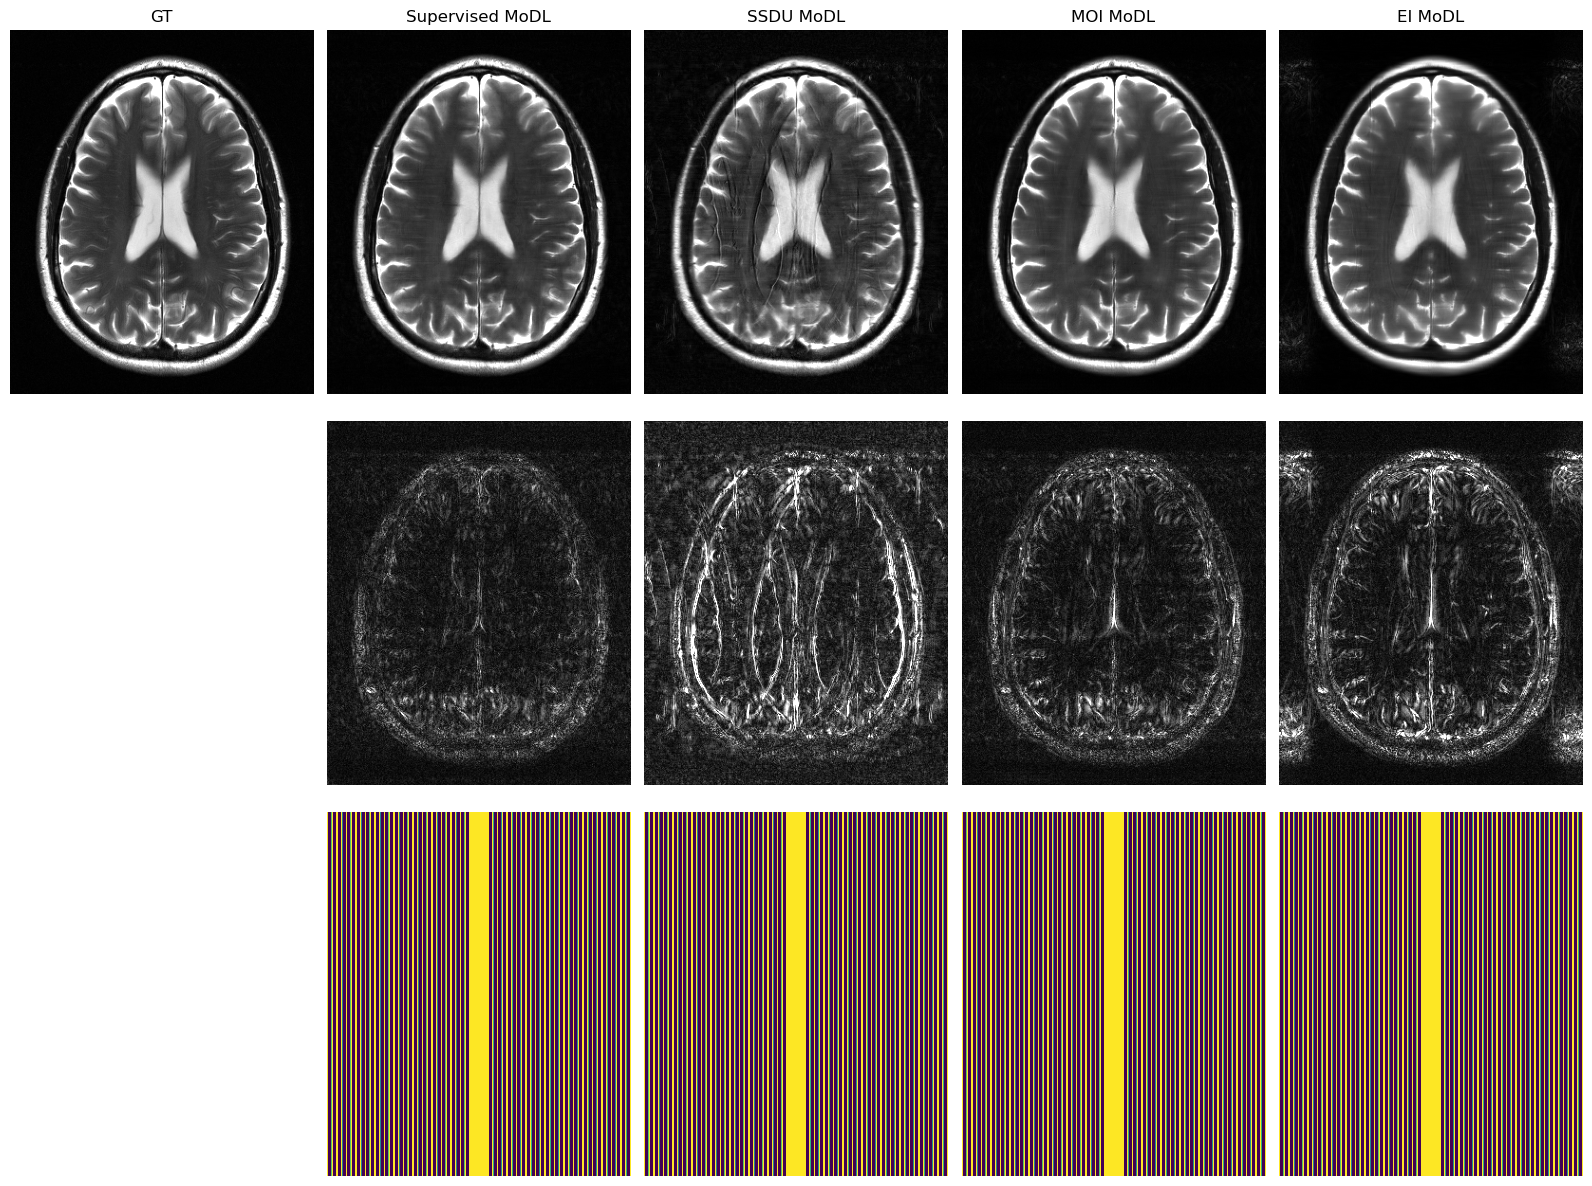

In [20]:
vmax = 1.2
d = .2
plt.figure(figsize=(16,12))
plt.subplot(3,5,1)
plt.title('GT')
plt.imshow(np.flipud(abs(gt_img.numpy())[0,0]),cmap='gray', vmax = vmax)
plt.axis('off')

# plt.subplot(2,4,2)
# plt.title('Adjoint')
# plt.imshow(np.flipud(abs(adj_recon.numpy())[0,0]),cmap='gray', vmax = vmax)
# plt.axis('off')
# plt.subplot(2,4,6)

# plt.imshow(np.flipud(abs(gt_img.numpy()-adj_recon.numpy())[0,0]),cmap='gray', vmax = d*vmax)
# plt.axis('off')


plt.subplot(3,5,2)
plt.title('Supervised MoDL')
plt.imshow(np.flipud(abs(x_MoDL.detach().numpy())[0]),cmap='gray', vmax = vmax)
plt.axis('off')
plt.subplot(3,5,7)
plt.imshow(np.flipud(abs(x_MoDL.detach().numpy()[0]-gt_img[0,0].numpy())),cmap='gray', vmax = d*vmax)
plt.axis('off')
plt.subplot(3,5,12)
plt.imshow(np.flipud(abs(fm_mask.cpu()[0,0])), vmax = d*vmax)
plt.axis('off')

plt.subplot(3,5,3)
plt.title('SSDU MoDL')
plt.imshow(np.flipud(abs(x_SSDU.detach().numpy())[0]),cmap='gray', vmax = vmax)
plt.axis('off')
plt.subplot(3,5,8)
plt.imshow(np.flipud(abs(x_SSDU.detach().numpy()[0]-gt_img[0,0].numpy())),cmap='gray', vmax = d*vmax)
plt.axis('off')
plt.subplot(3,5,13)
plt.imshow(np.flipud(abs(a_mask.cpu()[0,0])), vmax = d*vmax)
plt.axis('off')


plt.subplot(3,5,4)
plt.title('MOI MoDL')
plt.imshow(np.flipud(abs(x_MOI.detach().numpy())[0]),cmap='gray', vmax = vmax)
plt.axis('off')
plt.subplot(3,5,9)
plt.imshow(np.flipud(abs(x_MOI.detach().numpy()[0]-gt_img[0,0].numpy())),cmap='gray', vmax = d*vmax)
plt.axis('off')
plt.subplot(3,5,14)
plt.imshow(np.flipud(abs(a_mask.cpu()[0,0])), vmax = d*vmax)
plt.axis('off')

plt.subplot(3,5,5)
plt.title('EI MoDL')
plt.imshow(np.flipud(abs(x_EI.detach().numpy())[0]),cmap='gray', vmax = vmax)
plt.axis('off')
plt.subplot(3,5,10)
plt.imshow(np.flipud(abs(x_EI.detach().numpy()[0]-gt_img[0,0].numpy())),cmap='gray', vmax = d*vmax)
plt.axis('off')
plt.subplot(3,5,15)
plt.imshow(np.flipud(abs(a_mask.cpu()[0,0])), vmax = d*vmax)
plt.axis('off')



plt.tight_layout(pad = 1.0)


print('nrmse Supervsied MoDL: ',nrmse_MoDL)
print('nrmse Self Supe. MoDL: ',nrmse_SSDU)
print('nrmse Self Supe. MOI: ',nrmse_MOI)
print('nrmse Self Supe. EI: ',nrmse_EI)